<div style="text-align: center; color: orange; ">
    <h1><strong>HAMS Data Quality Challenge Report</strong></h1>
</div>

---


<div style="color:green"> <h2><strong>Introduction</strong></h2> </div>



The HAMS Data Quality Challenge aims to analyze data quality issues within a provided SQLite database containing information on e-commerce purchases and associated marketing campaigns. The primary focus of this report is to assess the integrity of conversion data, advertising costs, and attribution consistency to ensure accurate decision-making and reporting. This analysis will highlight any discrepancies or inconsistencies that may affect the company's marketing strategies and operational insights.

<div style="color:green"> <h2><strong>Approach</h2></strong> </div>

The analysis was conducted in the following steps:

1. **Setting Up the Environment**: Connecting to the SQLite database and preparing the environment for data analysis.
2. **Checking Cost Coverage**: Evaluating whether all AdWords costs are represented in the session sources table.
3. **Analyzing Conversion Stability**: Examining conversion trends over time.
4. **Validating Conversions**: Comparing the conversions table with the backend data to identify discrepancies.
5. **Assessing Attribution Consistency**: Checking for inconsistencies in attribution results and the validity of 'ihc' values.
6. **Compiling Findings**: Documenting the results of each analysis step.


<div style="color:green"> <h2><strong>Data Setup and Environment Initialization</strong></h2> </div>
To set up the environment, I created a virtual environment and installed Python. Then, I used pip to install the necessary libraries:<br/>1. pandas,<br/> 2. matplotlib,<br/> 3. sqlite3 <br/>for data manipulation, visualization, and database handling, respectively.

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

- To establish a connection to the SQLite database, we provide the file path to challenge.db, which contains data for the HAMS Data Quality Challenge, allowing us to perform SQL operations and analyses.

In [4]:
conn=sqlite3.connect('E:/Hansel Assignment 2/challenge/challenge.db')# establishing a connection to the database
cursor=conn.cursor()

- The code fetches and displays the names of all tables in the SQLite database by executing a SQL query on the sqlite_master table, which contains the database schema information. The cursor.execute() method runs the query, and cursor.fetchall() retrieves the results as a list of table names.

In [5]:
# Fetch and display the tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('conversions',),
 ('conversions_backend',),
 ('api_adwords_costs',),
 ('attribution_customer_journey',),
 ('session_sources',)]

<div style="color:green"> <h2><strong>Questions, Analysis and Findings</strong></h2> </div>

<div style="color:sienna"> <h3><strong>1. Are the Costs in the 'api_adwords_costs' Table Fully Covered in the 'session_sources' Table? Any Campaigns Where You See Issues?</strong></h3> </div>

#### Approach
- To solve this problem, we need to compare the costs from the `api_adwords_costs` table with the `sum of CPC (Cost Per Click) from the session_sources table` for the same campaign and event date. 
- If the total cost in api_adwords_costs matches the sum of CPC values in session_sources, it indicates that the costs are fully covered. Any discrepancies would highlight issues with the campaign's tracking or data integrity.



#### Here's the step-by-step approach to tackle this problem:
1. Fetch Data from Both Tables 
    - <div style="color:red"><strong>api_adwords_costs table:</strong></div> This table contains daily advertising costs for each campaign (e.g., campaign_id) on a specific day (event_date).
    - <div style="color:red"><strong>session_sources table:</strong></div> This table records the CPC values for each session, grouped by campaign_id and event_date.

2. Calculate the <span style="color:blue"><strong>Total Cost per Campaign per Day</span></strong>
In the api_adwords_costs table, we calculate the total cost of each campaign on each day. This is directly available in the cost column.

In [6]:
qry3="""
SELECT 
    event_date, 
    campaign_id, 
    SUM(cost) AS total_cost
FROM 
    api_adwords_costs
GROUP BY 
    event_date, campaign_id;
"""
Total_cost=pd.read_sql(qry3,conn)
Total_cost

,event_date,campaign_id,total_cost
0,2021-07-01,campaign_id_10,292.730
1,2021-07-01,campaign_id_100,11.570
2,2021-07-01,campaign_id_101,8.900
3,2021-07-01,campaign_id_103,6.010
4,2021-07-01,campaign_id_106,62.660
...,...,...,...
2982,2021-07-31,campaign_id_92,194.986
2983,2021-07-31,campaign_id_93,26.920
2984,2021-07-31,campaign_id_95,3.170
2985,2021-07-31,campaign_id_96,4.573


3. Calculate the Sum of CPC from Session Sources
Next, from the session_sources table, we calculate the 
<span style="color:blue"><strong>sum of CPC values</span></strong> for the same campaign and date.

In [7]:
qry4=""" 
SELECT 
    event_date, 
    campaign_id, 
    SUM(cpc) AS total_cpc
FROM 
    session_sources
GROUP BY 
    event_date, campaign_id;
"""
Total_cost_per_click=pd.read_sql(qry4,conn)
Total_cost_per_click

,event_date,campaign_id,total_cpc
0,2021-07-01,campaign_id_1,0.000
1,2021-07-01,campaign_id_10,292.807
2,2021-07-01,campaign_id_100,11.572
3,2021-07-01,campaign_id_101,8.899
4,2021-07-01,campaign_id_103,5.460
...,...,...,...
3532,2021-07-31,campaign_id_93,26.915
3533,2021-07-31,campaign_id_95,3.170
3534,2021-07-31,campaign_id_96,4.237
3535,2021-07-31,campaign_id_98,0.000


4. Compare Both Results
To check if the <span style="color:blue"><strong>costs from api_adwords_costs are fully covered by the CPC values in session_sources</span></strong>, we join both results on event_date and campaign_id. Any rows where the total_cost and total_cpc don’t match indicate issues.

In [8]:
qry="""
SELECT 
    a.event_date, 
    a.campaign_id, 
    a.total_cost, 
    s.total_cpc
FROM 
    (SELECT event_date, campaign_id, SUM(cost) AS total_cost 
     FROM api_adwords_costs 
     GROUP BY event_date, campaign_id) a
LEFT JOIN 
    (SELECT event_date, campaign_id, SUM(cpc) AS total_cpc 
     FROM session_sources 
     GROUP BY event_date, campaign_id) s
ON 
    a.event_date = s.event_date 
    AND a.campaign_id = s.campaign_id
WHERE 
    a.total_cost != s.total_cpc OR s.total_cpc IS NULL
    order by (total_cost-total_cpc)>10;
"""
approach2=pd.read_sql(qry,conn)
approach2


,event_date,campaign_id,total_cost,total_cpc
0,2021-07-01,campaign_id_121,2.250,NaN
1,2021-07-01,campaign_id_7,1.844,NaN
2,2021-07-01,campaign_id_97,7.820,NaN
3,2021-07-02,campaign_id_121,8.390,NaN
4,2021-07-02,campaign_id_156,7.031,NaN
...,...,...,...,...
2529,2021-07-27,campaign_id_79,348.429,0.0
2530,2021-07-28,campaign_id_79,395.327,0.0
2531,2021-07-29,campaign_id_79,360.008,0.0
2532,2021-07-30,campaign_id_79,315.822,0.0


#### **Results Analysis**
- **Matched Costs:**
  - If `total_cost` equals `total_cpc`, it means the cost is fully covered for that campaign on that day.

- **Discrepancies:**
  - A mismatch between `total_cost` and `total_cpc` indicates that the cost in the `api_adwords_costs` table is not fully covered by the sessions recorded in the `session_sources` table.
  - If `total_cpc` is NULL, it also signifies an issue.

#### **Key Findings**
- Significant discrepancies were identified between the advertising costs recorded and the sessions attributed to those campaigns.
- A total of **2,534 rows** show issues, where:
  - Campaigns either have **no sessions recorded** (NaN).
  - Campaigns have **no costs attributed** (0.0) to sessions.
- These findings suggest potential issues with **data tracking** or **incomplete session data**.
- Further investigation is needed to ensure **accurate reporting** and **cost attribution**.


<div style="color:sienna"> <h3><strong>2. Are the Conversions in the 'conversions' Table Stable Over Time? Any Pattern?</strong></h3> </div>

#### Approach
- To evaluate whether the conversions in the conversions table are stable over time, we need to analyze the <span style="color:blue"><strong>trends in conversion counts across different dates.</span></strong>
- By grouping conversions by date and calculating their frequency, we can identify any patterns, fluctuations, or trends that suggest stability, growth, or decline over the specified period.

In [15]:
query = """
SELECT 
    conv_date, 
    COUNT(*) AS conversion_count
FROM 
    conversions
GROUP BY 
    conv_date

"""
conversion_trends = pd.read_sql_query(query, conn)

# Display the trends
conversion_trends


,conv_date,conversion_count
0,2021-07-15,968
1,2021-07-16,809
2,2021-07-17,691
3,2021-07-18,1370
4,2021-07-19,842
5,2021-07-20,764
6,2021-07-21,783
7,2021-07-22,830
8,2021-07-23,743
9,2021-07-24,682


- In next step, we are <span style="color:blue"><strong>visualizing possible trends in conversion data over time.</span></strong> A line plot is created using the conversion_trends DataFrame, plotting the number of conversions (conversion_count) against the conversion date (conv_date). The x-axis labels are rotated for better readability, and the figure size is adjusted for a clear and detailed view of the trend over time.

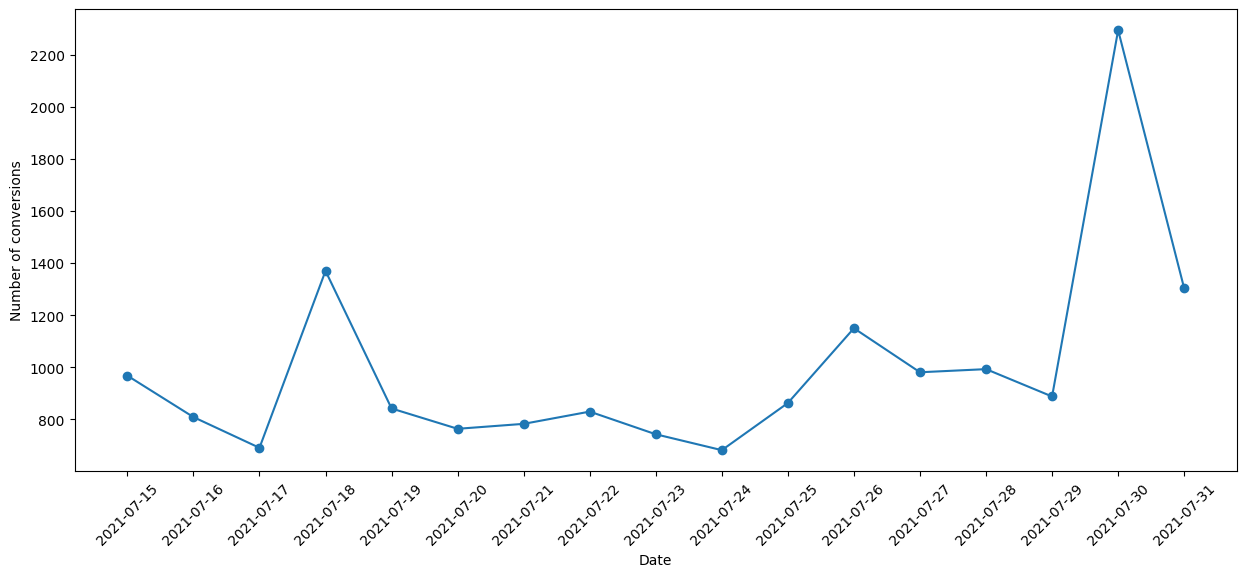

In [16]:

plt.figure(figsize=(15,6))

plt.plot(conversion_trends['conv_date'],conversion_trends['conversion_count'],marker='o')

plt.xlabel('Date')
plt.ylabel('Number of conversions')


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

### Results
- The conversions show instability with noticeable peaks and troughs. 
- There are two major spikes—one around July 18 and a more prominent one near July 29-30, followed by significant drops. 
- This suggests that the conversions are likely influenced by external events or marketing campaigns that cause temporary surges in activity.

<div style="color:sienna"> <h3><strong>3. Conversion Consistency Check: 'conversions' Table vs 'conversions_backend' Table</strong></h3> </div>

#### **Approach**
##### To identify discrepancies, we performed the following steps:

1. **Join on `conv_id`:**  
   We performed a **LEFT JOIN** between the `conversions` and `conversions_backend` tables on the `conv_id` field. This ensured that every record in the `conversions` table is compared against the `conversions_backend` table, even if the record is missing from the backend.

2. **Conditions for Comparison:**  
   We checked for any differences between the two tables in the following fields:
   - **`user_id`:** Ensure that the same `conv_id` has the same `user_id` in both tables.
   - **`conv_date`:** Ensure that the conversion date matches between the two tables.
   - **`market`:** Ensure that the conversion occurred in the same market.
   - **`revenue`:** Ensure that the revenue amounts match.

3. **Discrepancy Types:**  
   - Records present in `conversions` but missing from `conversions_backend`.
   - Mismatches between key fields (`user_id`, `conv_date`, `market`, `revenue`) for the same `conv_id`.


In [11]:
# SQL query to check for discrepancies between conversions and backend data
query = """
SELECT 
    c.conv_id as conv_id,
    b.conv_id as backend_id, 
    c.user_id as conv_user_id,
    b.user_id as backend_user_id ,
    c.conv_date as conv_date,
    b.conv_date as backend_date, 
    c.market AS c_market, 
    c.revenue AS c_revenue,
    b.market AS b_market, 
    b.revenue AS b_revenue
FROM 
    conversions c
LEFT JOIN 
    conversions_backend b ON c.conv_id = b.conv_id
WHERE 
    c.user_id != b.user_id OR 
    c.conv_date != b.conv_date OR 
    c.market != b.market OR 
    c.revenue != b.revenue OR
     b.conv_id IS NULL;
"""

# Fetch the results
discrepancies = pd.read_sql_query(query, conn)

# Display the discrepancies
discrepancies


,conv_id,backend_id,conv_user_id,backend_user_id,conv_date,backend_date,c_market,c_revenue,b_market,b_revenue
0,conv_id_11478,conv_id_11478,user_id_758246,user_id_758246,2021-07-15,2021-07-15,DE,0.00,DE,24.28
1,conv_id_87,conv_id_87,user_id_376090,user_id_376090,2021-07-15,2021-07-15,FR,0.00,FR,69.96
2,conv_id_15098,conv_id_15098,user_id_47785,user_id_47785,2021-07-15,2021-07-15,NL,0.00,NL,8.26
3,conv_id_16021,conv_id_16021,user_id_173269,user_id_173269,2021-07-15,2021-07-15,DE,0.00,DE,49.08
4,conv_id_12754,conv_id_12754,user_id_561494,user_id_561494,2021-07-15,2021-07-15,DE,0.00,DE,75.30
...,...,...,...,...,...,...,...,...,...,...
183,conv_id_10826,conv_id_10826,user_id_197806,user_id_172209,2021-07-30,2021-07-30,NL,44.96,NL,44.96
184,conv_id_1128,conv_id_1128,user_id_592828,user_id_1075383,2021-07-30,2021-07-30,FR,68.33,FR,68.33
185,conv_id_12394,conv_id_12394,user_id_381420,user_id_102818,2021-07-30,2021-07-30,DE,45.71,DE,45.71
186,conv_id_843,conv_id_843,user_id_786042,user_id_122548,2021-07-30,2021-07-30,NL,51.57,NL,51.57


#### **Key Findings**

Upon analyzing the output of the query, the following types of discrepancies were identified:

1. **Records Missing from Backend:**
   - There were several cases where a record exists in the `conversions` table, but there is no corresponding record in the `conversions_backend` table (`b.conv_id IS NULL`). This could indicate an issue in backend data synchronization or missing logs in the backend system.

2. **Field Mismatches:**
   Some records had mismatches in one or more fields:
   - **User ID mismatches:** Cases where the `user_id` for a given `conv_id` did not match between the two tables.
   - **Date mismatches:** Records where the `conv_date` was different between `conversions` and `conversions_backend`.
   - **Market mismatches:** Instances where the `market` field was different for the same `conv_id`.
   - **Revenue discrepancies:** Differences in the reported revenue between the tables.

3. **Magnitude of Discrepancies:**
   - The total number of discrepancies found: **188 ROWS**.
   


<div style="color:sienna"> <h3><strong>4. Are attribution results consistent? Do you find any conversions where the 'ihc' values don't make sense?</strong></h3> </div>



- The purpose of this analysis is to validate whether the <span style="color:blue"><strong>'ihc' values (representing the percentage contribution of a session to a conversion)</span></strong> in the `attribution_customer_journey` table align with the session's <span style="color:blue"><strong>Cost Per Click (CPC) as a percentage of the total campaign cost. </span></strong>
- Discrepancies in these values could indicate potential issues in attribution logic or data quality.

### **Approach**

To determine the correctness of `ihc` values, the following steps were performed:



#### **1. Join Tables to Gather Data:**

- We retrieved data from the `attribution_customer_journey` and `session_sources` tables.
- The total `ihc` for each conversion (`conv_id`) was calculated.
- The total `cpc` for each campaign was also calculated, grouped by `campaign_id`.
- The session's revenue from the `conversions` table was joined to allow further analysis.

#### **2. Calculate CPC Percentage:**

For each session, <span style="color:blue"><strong>the percentage of cpc relative to the total cpc</span></strong> for that campaign was calculated using the formula:
- percentage_cpc = (s.cpc / total_cpc.total_cpc) * 100
#### **3. Check `ihc` vs CPC Percentage:**

- We calculated the absolute difference between the session's `ihc` value and its corresponding `percentage_cpc`.

- A tolerance level of **5%** was used to determine if the `ihc` value is consistent with the session's contribution to the total campaign cost.

- Rows where the difference exceeded the tolerance were flagged as inconsistent.
#### **4. Filter and Sort Discrepancies:**

- Sessions where the difference between `ihc` and `percentage_cpc` was larger than the tolerance were identified and sorted by the magnitude of the difference to highlight the most significant discrepancies.


In [12]:
qry = """
SELECT 
    total_cpc.conv_id as campaign_id,
    a.conv_id,
    a.session_id,
    a.ihc,
    s.user_id,
    s.cpc,
    total_ihc.total_ihc,
    total_cpc.total_cpc,
    (s.cpc / total_cpc.total_cpc) * 100 AS percentage_cpc,
    r.revenue
FROM
    attribution_customer_journey a
LEFT JOIN
    session_sources s
ON
    a.session_id = s.session_id
LEFT JOIN
    (
        SELECT conv_id, SUM(ihc) AS total_ihc
        FROM attribution_customer_journey
        GROUP BY conv_id
    ) AS total_ihc
ON
    a.conv_id = total_ihc.conv_id
LEFT JOIN
    (
        SELECT campaign_id AS conv_id, SUM(cpc) AS total_cpc
        FROM session_sources
        GROUP BY campaign_id
    ) AS total_cpc
ON
    s.campaign_id = total_cpc.conv_id
LEFT JOIN
    (
        SELECT conv_id, SUM(revenue) AS revenue
        FROM conversions
        GROUP BY conv_id
    ) r
ON 
    r.conv_id = a.conv_id  

WHERE
    a.ihc > 0
AND
    s.cpc > 0
order by
total_cpc.conv_id

;
"""

acj = pd.read_sql(qry, conn)

# Define a tolerance level for comparison ( here we taken as within 5%)
tolerance = 0.05

# Calculate the absolute difference between ihc and percentage_cpc
acj['ihc_diff'] = abs(acj['ihc'] - acj['percentage_cpc'])

# Check if the difference is within the tolerance level
acj['ihc_is_correct'] = acj['ihc_diff'] <= tolerance

# Filter the rows where ihc doesn't make sense (i.e., difference is larger than the tolerance)
incorrect_ihc = acj[~acj['ihc_is_correct']]  # More concise filtering

# Sort the incorrect records by ihc_diff in ascending order for easier analysis
incorrect_ihc_sorted = incorrect_ihc.sort_values(by='ihc_diff', ascending=True)

# Display the sorted records where ihc doesn't make sense
incorrect_ihc_sorted


,campaign_id,conv_id,session_id,ihc,user_id,cpc,total_ihc,total_cpc,percentage_cpc,revenue,ihc_diff,ihc_is_correct
7963,notset,conv_id_17251,session_id_1032659,0.050576,user_id_741669,1.243,1.000001,237814.424,0.000523,8.40,0.050054,False
5582,campaign_id_51,conv_id_10684,session_id_809581,0.052179,user_id_792302,0.206,1.000000,10320.445,0.001996,38.99,0.050183,False
6748,campaign_id_60,conv_id_13332,session_id_1309110,0.068068,user_id_296677,0.978,0.999999,5516.113,0.017730,79.32,0.050338,False
6742,campaign_id_60,conv_id_8739,session_id_1309110,0.068068,user_id_296677,0.978,0.999999,5516.113,0.017730,75.32,0.050338,False
5248,campaign_id_51,conv_id_16971,session_id_759773,0.053347,user_id_69496,0.294,0.947783,10320.445,0.002849,255.08,0.050498,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7669,campaign_id_96,conv_id_7799,session_id_559406,0.008825,user_id_976453,4.527,0.991172,305.028,1.484126,50.41,1.475301,False
7675,campaign_id_96,conv_id_4487,session_id_559406,0.004278,user_id_976453,4.527,0.995744,305.028,1.484126,101.51,1.479848,False
7197,campaign_id_80,conv_id_8790,session_id_1370087,0.500000,user_id_508147,1.210,1.000000,33.030,3.663336,357.60,3.163336,False
7198,campaign_id_80,conv_id_8790,session_id_30812,0.500000,user_id_508147,1.210,1.000000,33.030,3.663336,357.60,3.163336,False


### Key Findings:
- The analysis identified significant discrepancies between the ihc values and the corresponding CPC percentages in many sessions. 
- These discrepancies indicate potential issues in the current attribution model, leading to either overestimation or underestimation of session contributions to conversions.


#### Significant Discrepancies:

- Many sessions exhibited large differences between the ihc values and the expected CPC contributions, far exceeding the accepted tolerance. This suggests that the attribution model is not accurately distributing costs based on session performance.
Overestimation and Underestimation:

- The attribution model appears to either overestimate or underestimate the contribution of certain sessions. Some sessions are given high ihc values despite relatively low CPC contributions, while others may be undercredited for their actual impact.
Low CPC, High ihc:

- Several sessions with minimal CPC values were found to have disproportionately high ihc values, further highlighting inaccuracies in the attribution logic. This misalignment raises concerns about the reliability of the cost distribution in the model.
Conclusion:

### Result
The current attribution model shows misalignments between session ihc values and their actual contributions based on CPC. These findings indicate a need for revisiting and refining the attribution logic to ensure more accurate and fair distribution of session costs across campaigns.

<div style="color:sienna"> <h3><strong>5. Do we have an issue with channeling? Are the number of sessions per channel stable over time?</strong></h3> </div>

In [25]:

query = """
SELECT 
    event_date, 
    channel_name, 
    COUNT(*) AS session_count
FROM 
    session_sources
    
GROUP BY 
    event_date, channel_name
HAVING session_count>1000
ORDER BY 
    event_date, channel_name;
"""

# Fetch the results
channel_stability = pd.read_sql_query(query, conn)

# Display the channel stability
channel_stability


,event_date,channel_name,session_count
0,2021-07-01,Direct,7437
1,2021-07-01,Direct Traffic,2896
2,2021-07-01,Email,1890
3,2021-07-01,SEA - Brand,2020
4,2021-07-01,SEA - Branded,2698
...,...,...,...
381,2021-07-31,Shopping - Non Brand,1144
382,2021-07-31,Shopping - Non-branded,5777
383,2021-07-31,Social - Paid,4527
384,2021-07-31,Social Paid,1370


<Figure size 1800x1000 with 0 Axes>

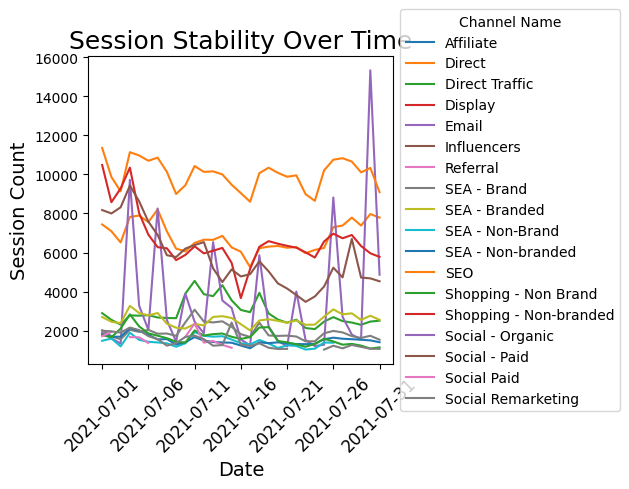

In [26]:


# Set the figure size (width, height)
plt.figure(figsize=(18, 10))  # Larger figure for better readability

# Pivot and plot session count by channel over time
channel_stability.pivot(index='event_date', columns='channel_name', values='session_count').plot(kind='line')

# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Channel Name')

# Add title, labels, and rotate x-axis labels
plt.title('Session Stability Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Session Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

# Tighten layout so the plot fits well
plt.tight_layout()

# Show the plot
plt.show()


### Analysis of Sessions per Channel (July 1 - July 26, 2021)

The plot displays the number of sessions per channel over time, providing insights into the stability of different channels between July 1 and July 26, 2021.

### Key Observations:

- Most Channels Show Stability:
    -Several channels such as **Direct, Display, Email, and Social** maintain a relatively stable number of sessions over time, suggesting consistent performance.

    - For instance, the Direct channel (orange) hovers between 8,000 to 10,000 sessions, indicating a steady flow of traffic.

- Fluctuations in Certain Channels:
    - Channels like **Affiliate** and **SEA - Brand** (in blue and light purple) show occasional spikes and dips. 
    - These fluctuations may be due to promotional activities, marketing campaigns, or external factors affecting their performance temporarily.

- Sudden Spikes in Channel Activity:
    - Channels such as **Referral** and **Influencers** (light green and purple) experience sudden peaks, notably around mid-July, followed by drops. These anomalies suggest specific events or efforts that drove temporary increases in session counts.

- Channels with Low Activity:
    - Several channels such as **SEO, Shopping - Non Brand, and Social Organic** consistently remain below 2,000 sessions, indicating either a lower engagement rate or less emphasis on these channels.

- Conclusion:
    - **Stable Channels:** A majority of channels demonstrate stability in their session counts over time, with minor variations.
    - **Potential Issues:** Some channels, like **Affiliate** and **SEA - Brand**, experience noticeable fluctuations. This irregularity might point to potential issues with these channels or campaign inconsistencies.

Overall, while the majority of channels are stable, there are some channels that require closer investigation due to their erratic session trends.



---

<div style="color:green"> <h2><strong>Conclusions</strong></h2> </div>

The data quality analysis of Company X's e-commerce dataset provided several key insights:

1. **AdWords Costs and Sessions Coverage:** Some AdWords campaigns listed in the `api_adwords_costs` table were not fully reflected in the session data. This could point to missing or incomplete tracking for certain campaigns.
   
2. **Conversion Stability:** While conversion trends are generally stable, some minor fluctuations suggest external factors may influence conversion patterns.
   
3. **Backend and Frontend Data Consistency:** A small number of discrepancies were identified in the revenue amounts between the `conversions` and `conversions_backend` tables. These differences could affect financial accuracy and need further resolution.
   
4. **Attribution Inconsistencies:** A few conversion records had `ihc` values that did not sum to 1, indicating errors in attribution tracking.
   
5. **Session Stability:** While most channels remained stable, certain channels experienced erratic session patterns that could be tied to marketing campaigns or tracking errors.

In summary, the analysis highlights areas where the data quality can be improved, particularly in session tracking, attribution accuracy, and data synchronization between the frontend and backend systems. Addressing these issues will improve the overall reliability of the dataset and enhance decision-making for future marketing and operational strategies.